# Bibliotecas

In [210]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, HuberRegressor, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Funções Auxiliares

In [147]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def plot_history(history):
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.ylim(0,6000000000)
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation MSE')
    plt.subplot(1, 2, 2)
    plt.ylim(0,100000)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Carregando os Dados

In [39]:
df = pd.read_csv("./dados_regressao.csv")

In [40]:
df.head()

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,...,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,...,12.0,922289.0,2003.0,Acima de 17 anos,90000.0,False,True,1.0,72600.0,2020-02-03T20:57:33
1,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,...,12.0,1485136.0,2014.0,De 6 a 10 anos,20000.0,False,False,1.0,5760.0,2020-02-04T16:40:49
2,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,...,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.0,89000.0,2020-02-04T15:06:28
3,7,Alexander Baker-Wells,Dr. Caroline Ali,PYOL43118620147076,16,0.000000,NaN,2011-03-02T11:27:13,0,0.00,...,12.0,45795943.0,2004.0,De 11 a 16 anos,30515674.0,True,False,0.0,20635703.0,2020-02-05T14:31:22
4,8,Jean Berry,Gregory Gould,NLUX93496216176463,4,0.350175,0.0,2007-07-02T00:00:00,102,208980.00,...,9.0,0.0,2000.0,Acima de 17 anos,120000.0,False,False,1.0,768233.0,2020-02-05T20:05:40


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   numero_solicitacao           5095 non-null   int64  
 1   razaoSocial                  5095 non-null   object 
 2   nomeFantasia                 5095 non-null   object 
 3   cnpjSemTraco                 5095 non-null   object 
 4   maiorAtraso                  5095 non-null   int64  
 5   margemBrutaAcumulada         5095 non-null   float64
 6   percentualProtestos          4300 non-null   float64
 7   primeiraCompra               5061 non-null   object 
 8   prazoMedioRecebimentoVendas  5095 non-null   int64  
 9   titulosEmAberto              5095 non-null   float64
 10  valorSolicitado              5095 non-null   float64
 11  status                       5095 non-null   object 
 12  definicaoRisco               5095 non-null   object 
 13  diferencaPercentua

In [42]:
df_num = df.drop(['cnpjSemTraco', 'percentualProtestos', 'dataAprovadoEmComite', 'dataAprovadoNivelAnalista', 'numero_solicitacao', 'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao',
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'restricoes', 'empresa_MeEppMei'], axis=1)

In [43]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  5095 non-null   int64  
 1   margemBrutaAcumulada         5095 non-null   float64
 2   prazoMedioRecebimentoVendas  5095 non-null   int64  
 3   titulosEmAberto              5095 non-null   float64
 4   valorSolicitado              5095 non-null   float64
 5   percentualRisco              5095 non-null   float64
 6   valorAprovado                5095 non-null   float64
 7   ativoCirculante              5095 non-null   float64
 8   passivoCirculante            5095 non-null   float64
 9   totalAtivo                   5095 non-null   float64
 10  totalPatrimonioLiquido       5095 non-null   float64
 11  endividamento                5095 non-null   float64
 12  duplicatasAReceber           5095 non-null   float64
 13  estoque           

In [44]:
for coluna in df_num.columns:
    data = df_num[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

Outliers na coluna maiorAtraso : 11.27%
Outliers na coluna margemBrutaAcumulada : 0.12%
Outliers na coluna prazoMedioRecebimentoVendas : 5.99%
Outliers na coluna titulosEmAberto : 16.13%
Outliers na coluna valorSolicitado : 12.44%
Outliers na coluna percentualRisco : 0.47%
Outliers na coluna valorAprovado : 13.09%
Outliers na coluna ativoCirculante : 12.97%
Outliers na coluna passivoCirculante : 14.45%
Outliers na coluna totalAtivo : 13.29%
Outliers na coluna totalPatrimonioLiquido : 13.82%
Outliers na coluna endividamento : 17.98%
Outliers na coluna duplicatasAReceber : 12.86%
Outliers na coluna estoque : 13.54%
Outliers na coluna faturamentoBruto : 13.37%
Outliers na coluna margemBruta : 13.31%
Outliers na coluna custos : 13.6%
Outliers na coluna capitalSocial : 14.66%
Outliers na coluna scorePontualidade : 19.39%
Outliers na coluna limiteEmpresaAnaliseCredito : 16.7%


In [45]:
for column in df_num.columns:
    data = df_num[column]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((data < minimum) | (data > maximum))
    df_num[column].loc[outliers] = np.nan
    
df_num.dropna(inplace=True)    

In [46]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2194 entries, 0 to 5093
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   maiorAtraso                  2194 non-null   float64
 1   margemBrutaAcumulada         2194 non-null   float64
 2   prazoMedioRecebimentoVendas  2194 non-null   float64
 3   titulosEmAberto              2194 non-null   float64
 4   valorSolicitado              2194 non-null   float64
 5   percentualRisco              2194 non-null   float64
 6   valorAprovado                2194 non-null   float64
 7   ativoCirculante              2194 non-null   float64
 8   passivoCirculante            2194 non-null   float64
 9   totalAtivo                   2194 non-null   float64
 10  totalPatrimonioLiquido       2194 non-null   float64
 11  endividamento                2194 non-null   float64
 12  duplicatasAReceber           2194 non-null   float64
 13  estoque           

In [151]:
x = df_num.drop('valorAprovado', axis=1)
y = df_num.valorAprovado

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [48]:
lm = LinearRegression()
linear = lm.fit(x_train, y_train)
y_pred = lm.predict(x_test)
linear.score(x_test, y_test)

0.7468735061927148

In [49]:
print('RMSE (root-mean-squared error): {}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

RMSE (root-mean-squared error): 26192.79821989001
16161.906715145598
686062678.5878732
26192.79821989001


In [15]:
ridge = Ridge()
lin_rdg = ridge.fit(x_train, y_train)
lin_rdg.score(x_test, y_test)

0.7472028491436262

In [17]:
elastic = ElasticNet()
lin_elastic = elastic.fit(x_train, y_train)
lin_elastic.score(x_test, y_test)

0.7431920830638917

In [176]:
mmsc = StandardScaler()
x_mmsc = mmsc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_mmsc, y, test_size=0.2, random_state=42)

In [211]:
model = Sequential()
model.add(Dense(128, input_dim=19, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

In [212]:
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex4.hdf5', verbose=1, save_best_only=True, monitor='val_mse')

model.compile(loss='mae', optimizer='adam', metrics=['mse'])
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[checkpointer])

Epoch 1/100
50/50 [==============================] - 1s 7ms/step - loss: 50454.6211 - mse: 5198723072.0000 - val_loss: 53156.9648 - val_mse: 5916490240.0000

Epoch 00001: val_mse improved from inf to 5916490240.00000, saving model to .\modelo_mlp_ex4.hdf5
Epoch 2/100
50/50 [==============================] - 0s 3ms/step - loss: 43779.7383 - mse: 4336138240.0000 - val_loss: 37257.0781 - val_mse: 3573597696.0000

Epoch 00002: val_mse improved from 5916490240.00000 to 3573597696.00000, saving model to .\modelo_mlp_ex4.hdf5
Epoch 3/100
50/50 [==============================] - 0s 3ms/step - loss: 29377.5410 - mse: 2014106624.0000 - val_loss: 27207.2051 - val_mse: 2012994048.0000

Epoch 00003: val_mse improved from 3573597696.00000 to 2012994048.00000, saving model to .\modelo_mlp_ex4.hdf5
Epoch 4/100
50/50 [==============================] - 0s 3ms/step - loss: 25516.0410 - mse: 1579192192.0000 - val_loss: 24153.8887 - val_mse: 1518508928.0000

Epoch 00004: val_mse improved from 2012994048.00

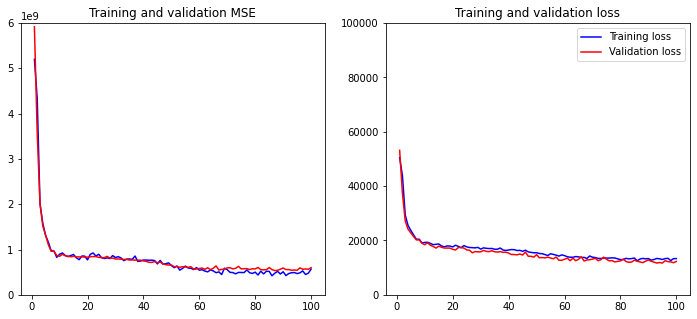

In [213]:
plot_history(history)

In [216]:
model = load_model("./modelo_mlp_ex4.hdf5")

In [217]:
y_pred = model.predict(x_test)

In [218]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

11579.24363121085
445077517.1623836
21096.860362679174
